A Simple RNN Task: 利用RNN的二元分类网络区分不同函数

In [3]:
%pip install torch numpy matplotlib 
# restart kernel after installation

Note: you may need to restart the kernel to use updated packages.


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
DATA_SIZE = 1000

sine_data_size = np.random.randint(int(0.3 * DATA_SIZE), int(0.7 * DATA_SIZE))
sigmoid_data_size = DATA_SIZE - sine_data_size

steps = np.arange(0, 10, 0.5)

# generate sine-like function samples
sine_init = np.random.uniform(-3, 3, (sine_data_size, 2))  # randomize a and b for sin(ax+b)
sine_data = np.sin(sine_init[:, :1] * steps + sine_init[:, 1:])

# generate sigmoid-like function samples
sigmoid_init = np.random.uniform(-3, 3, (sigmoid_data_size, 2)) # randomize a and b for 1/(1+e^(-ax+b))
sigmoid_data = 1 / (1 + np.exp(0 - sigmoid_init[:, :1] * steps + sigmoid_init[:, 1:]))

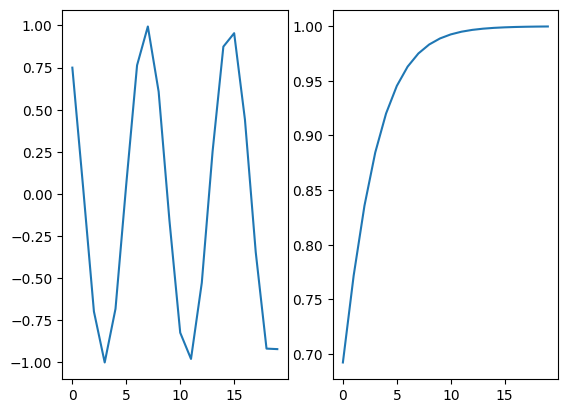

In [6]:
fig, axs = plt.subplots(1, 2)
axs[0].plot(sine_data[0])
axs[1].plot(sigmoid_data[1])

In [7]:
# mix data
sine_data = np.concatenate((sine_data, np.ones((sine_data_size, 1))), axis=1)
sigmoid_data = np.concatenate((sigmoid_data, np.zeros((sigmoid_data_size, 1))), axis=1)
data = np.concatenate((sine_data, sigmoid_data), axis=0)
data = torch.Tensor(data)

In [8]:
# split two datasets

from torch.utils.data import random_split
train_set, test_set = random_split(data, [0.8, 0.2])


In [37]:
# define network

class SimpleClassificationRNN(nn.Module):
    def __init__(self, hidden_size):
        super(SimpleClassificationRNN, self).__init__()
        '''
        task 1: write network structure here using nn.RNN
        '''
        self.rnn = nn.RNN(input_size=1,
                          hidden_size=hidden_size,
                          batch_first=True,
                          num_layers=1)
        self.linear = nn.Linear(hidden_size, 1)
    def forward(self, seq, hc=None):
        '''
        task 2: write forward process
        '''
        tmp, hc = self.rnn(seq, hc)
        out = torch.sigmoid(self.linear(hc[-1, ... ,:]))
        return out, hc

In [39]:
hidden_size = 16
learning_rate = 0.01

model = SimpleClassificationRNN(hidden_size)

'''
task 3: select appropriate criterion and optimizer
'''
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), learning_rate)


In [40]:
def cal_accuracy(preds, true_values):
    preds = torch.where(preds>0.5, 1, 0)
    acc = torch.sum(1-torch.abs(preds-true_values)) / preds.shape[0]
    return acc

In [41]:
# training ...

epochs = 500
loss_log = []
for epoch in range(epochs):
    optimizer.zero_grad()
    output, _ = model(train_set[:][:, :-1, np.newaxis])
    loss = criterion(output.view(-1), train_set[:][:, -1])
    acc = cal_accuracy(output.view(-1), train_set[:][:, -1])
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print("Epoch {}: loss {} acc {}".format(epoch, loss.item(), acc))

Epoch 0: loss 0.6851213574409485 acc 0.5375000238418579
Epoch 10: loss 0.4821777045726776 acc 0.7912499904632568
Epoch 20: loss 0.44051045179367065 acc 0.8162500262260437
Epoch 30: loss 0.4097538888454437 acc 0.8274999856948853
Epoch 40: loss 0.3841544985771179 acc 0.84375
Epoch 50: loss 0.23077453672885895 acc 0.9437500238418579
Epoch 60: loss 0.15053796768188477 acc 0.9462500214576721
Epoch 70: loss 0.08281320333480835 acc 0.987500011920929
Epoch 80: loss 0.06717051565647125 acc 0.981249988079071
Epoch 90: loss 0.0556727834045887 acc 0.987500011920929
Epoch 100: loss 0.1986059993505478 acc 0.90625
Epoch 110: loss 0.05517578125 acc 0.9850000143051147
Epoch 120: loss 0.05737805366516113 acc 0.987500011920929
Epoch 130: loss 0.21666567027568817 acc 0.8999999761581421
Epoch 140: loss 0.054150745272636414 acc 0.987500011920929
Epoch 150: loss 0.04493436962366104 acc 0.9887499809265137
Epoch 160: loss 0.04013776779174805 acc 0.9912499785423279
Epoch 170: loss 0.040856942534446716 acc 0.988

In [26]:
# performance on test set

output, _ = model(test_set[:][:, :-1, np.newaxis])
loss = criterion(output.view(-1), test_set[:][:, -1])
acc = cal_accuracy(output.view(-1), test_set[:][:, -1])

print("Test set: loss {} acc {}".format(loss.item(), acc))

Test set: loss 0.1159488782286644 acc 0.9750000238418579


## Example Solution

In [28]:
# define network

class SimpleClassificationRNN(nn.Module):
    def __init__(self, hidden_size):
        super(SimpleClassificationRNN, self).__init__()
        self.rnn = nn.RNN(input_size=1,
                          hidden_size=hidden_size,
                          batch_first=True,
                          num_layers=1)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, seq, hc=None):
        tmp, hc = self.rnn(seq, hc)
        out = torch.sigmoid(self.linear(hc[-1, ... ,:]))
        return out, hc

In [29]:
hidden_size = 16
learning_rate = 0.01

model = SimpleClassificationRNN(hidden_size)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), learning_rate)

# you can also test other optimizers and learning_rate settings ...

In [30]:
def cal_accuracy(preds, true_values):
    preds = torch.where(preds>0.5, 1, 0)
    acc = torch.sum(1-torch.abs(preds-true_values)) / preds.shape[0]
    return acc

# you can also implement other metrics like F1 ...

In [31]:
epochs = 500
loss_log = []
for epoch in range(epochs):
    optimizer.zero_grad()
    output, _ = model(train_set[:][:, :-1, np.newaxis])
    loss = criterion(output.view(-1), train_set[:][:, -1])
    acc = cal_accuracy(output.view(-1), train_set[:][:, -1])
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print("Epoch {}: loss {} acc {}".format(epoch, loss.item(), acc))

# you can also implement early stopping here ...

Epoch 0: loss 0.7049266695976257 acc 0.5375000238418579
Epoch 10: loss 0.49526870250701904 acc 0.762499988079071
Epoch 20: loss 0.45036694407463074 acc 0.8125
Epoch 30: loss 0.4355268180370331 acc 0.8362500071525574
Epoch 40: loss 0.3595859408378601 acc 0.8525000214576721
Epoch 50: loss 0.195967897772789 acc 0.9437500238418579
Epoch 60: loss 0.09063282608985901 acc 0.9825000166893005
Epoch 70: loss 0.09793098270893097 acc 0.9762499928474426
Epoch 80: loss 0.06709516793489456 acc 0.987500011920929
Epoch 90: loss 0.06269176304340363 acc 0.987500011920929
Epoch 100: loss 0.057298000901937485 acc 0.987500011920929
Epoch 110: loss 0.05462922155857086 acc 0.9887499809265137
Epoch 120: loss 0.05327064171433449 acc 0.9887499809265137
Epoch 130: loss 0.05247850343585014 acc 0.9887499809265137
Epoch 140: loss 0.279277503490448 acc 0.9237499833106995
Epoch 150: loss 0.14721226692199707 acc 0.9649999737739563
Epoch 160: loss 0.11190564185380936 acc 0.9674999713897705
Epoch 170: loss 0.074432507157

In [32]:
output, _ = model(test_set[:][:, :-1, np.newaxis])
loss = criterion(output.view(-1), test_set[:][:, -1])
acc = cal_accuracy(output.view(-1), test_set[:][:, -1])

print("Test set: loss {} acc {}".format(loss.item(), acc))

Test set: loss 0.09918637573719025 acc 0.9750000238418579
